# Bessere Architektur der Faltungsbasis

Unser erstes Netz hat zwar gelernt die Bilder zu klassifizieren, die Genauigkeit ist jedoch ungenügend.

In diesem Notebook wollen wir das Netz verbessern in dem wir eine Standard-Architektur eines anderen Netzes importieren. Als relativ leichtgewichtiges Netz wird hier das sogenannte [Mobile-Net](https://arxiv.org/abs/1704.04861) ausgewählt. Dieses von Google entwickelte Netz ist besonders klein (im Sinne von: wenig Freiheitsgrade), so dass es sich auch auf mobilen Geräten wie Smartphones ausführen lässt.



# Transfer-Learning

Die Features die Faltungsbasis in visuellen Datensätzen lernt sind oft sehr ähnlich von Datensatz zu Datensatz. Daher können wir theoretisch auch eine Faltungsbasis benutzen, welche auf einem anderen, deutlich größeren Datensatz belernt wurde, anstatt komplett von vorn anzufangen. Diese Technik nennt man Transfer-Learning. 

In unserem Fall bietet es sich an, eine Faltungsbasis zu nehmen welch auf [Image-Net](image-net.org) vortrainiert wurde.

![](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/38211dc39e41273c0007889202c69f841e02248a/2-Figure1-1.png)

Transfer-Learning ist eine der wichtigsten Techniken in Deep Learning und erlaubt es gute Ergebnisse auch mit relativ wenig Daten zu erreichen.

In [0]:
from keras import layers 
from keras import models

from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

import pylab as pl

from keras.applications import MobileNet

TRAIN_DIR = 'Cat_Dog_data/train'
VALIDATION_DIR = 'Cat_Dog_data/test'

BATCH_SIZE = 16

TARGET_SIZE = (224,224)

In [8]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   brightness_range=(0.8,1.2))

datagen_validation = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(TRAIN_DIR,
                                                    target_size=TARGET_SIZE,
                                                    color_mode='rgb',
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary'
                                                   )

validation_generator = datagen_validation.flow_from_directory(VALIDATION_DIR,
                                                    target_size=TARGET_SIZE,
                                                    color_mode='rgb',
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


Eine vortrainierte Faltungsbasis für verschiedene Netzarchitekturen sind in fast allen DL-Frameworks vorhanden

In [0]:
conv_base = MobileNet(include_top=False,input_shape=(TARGET_SIZE[0],TARGET_SIZE[1],3))

Um den Berechnungsaufwand klein zu halten, trainieren wir nur unser draufgesetztes Fully-Connected und frieren die Gewichte der vortrainierten Faltungsbasis ein.

In [10]:
model = models.Sequential()

model.add(conv_base)
          
model.add(layers.Flatten())
          
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable=False
          
model.summary()          

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1605664   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 4,834,561
Trainable params: 1,605,697
Non-trainable params: 3,228,864
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [12]:
history = model.fit_generator(train_generator,
                    steps_per_epoch=100,
                    epochs=10,
                    validation_data=validation_generator,
                   validation_steps=50,
                    verbose=1)

Epoch 1/10
100/100 [==============================] - 29s 290ms/step - loss: 0.3348 - acc: 0.8831 - val_loss: 0.1486 - val_acc: 0.9487
Epoch 2/10
100/100 [==============================] - 25s 249ms/step - loss: 0.1908 - acc: 0.9356 - val_loss: 0.1262 - val_acc: 0.9650
Epoch 3/10
100/100 [==============================] - 25s 253ms/step - loss: 0.1415 - acc: 0.9525 - val_loss: 0.0725 - val_acc: 0.9800
Epoch 4/10
100/100 [==============================] - 26s 256ms/step - loss: 0.1788 - acc: 0.9469 - val_loss: 0.1195 - val_acc: 0.9695
Epoch 5/10
100/100 [==============================] - 26s 256ms/step - loss: 0.1716 - acc: 0.9556 - val_loss: 0.1345 - val_acc: 0.9663
Epoch 6/10
100/100 [==============================] - 25s 255ms/step - loss: 0.1215 - acc: 0.9537 - val_loss: 0.2033 - val_acc: 0.9600
Epoch 7/10
100/100 [==============================] - 26s 256ms/step - loss: 0.1484 - acc: 0.9581 - val_loss: 0.1657 - val_acc: 0.9569
Epoch 8/10
100/100 [==============================] - 2

Text(0, 0.5, 'Binary Accuracy')

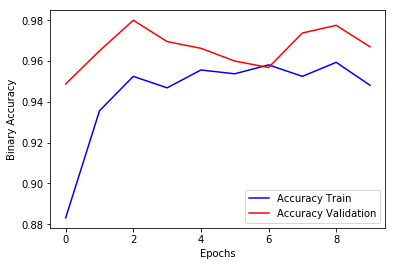

In [13]:
pl.plot(history.history['acc'],'b',label='Accuracy Train')
pl.plot(history.history['val_acc'],'r',label='Accuracy Validation')

pl.legend()
pl.xlabel('Epochs')
pl.ylabel('Binary Accuracy')

In [0]:
#model.save('mobilenet_frozen_weights.h5')